In [67]:
import pandas

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
file_name = 'cybersecurity_sample_filled.csv'
try:
    data = pd.read_csv(file_name)
    print(f"Successfully loaded '{file_name}'.")
except FileNotFoundError:
    print(f"Error: Could not find '{file_name}'.")

Successfully loaded 'cybersecurity_sample_filled.csv'.


In [70]:
print("\n--- Data Info ---")
data.info()


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           200 non-null    object 
 1   network_packet_size  200 non-null    int64  
 2   protocol_type        200 non-null    object 
 3   login_attempts       200 non-null    int64  
 4   session_duration     200 non-null    float64
 5   encryption_used      157 non-null    object 
 6   ip_reputation_score  200 non-null    float64
 7   failed_logins        200 non-null    int64  
 8   browser_type         200 non-null    object 
 9   unusual_time_access  200 non-null    int64  
 10  attack_detected      200 non-null    int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 17.3+ KB


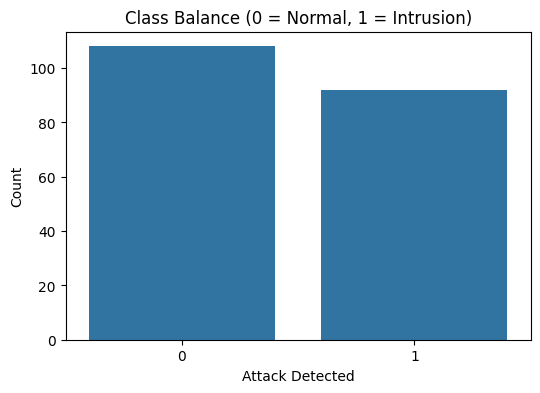

In [71]:
# --- 2. Target Variable Analysis (Class Balance) ---
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='attack_detected')
plt.title('Class Balance (0 = Normal, 1 = Intrusion)')
plt.ylabel('Count')
plt.xlabel('Attack Detected')
plt.savefig('eda_class_balance.png')
plt.show()

In [72]:
numeric_features_eda = [
        'network_packet_size', 'login_attempts', 'session_duration', 
        'ip_reputation_score', 'failed_logins', 'unusual_time_access'
    ]


Generating Pairplot...


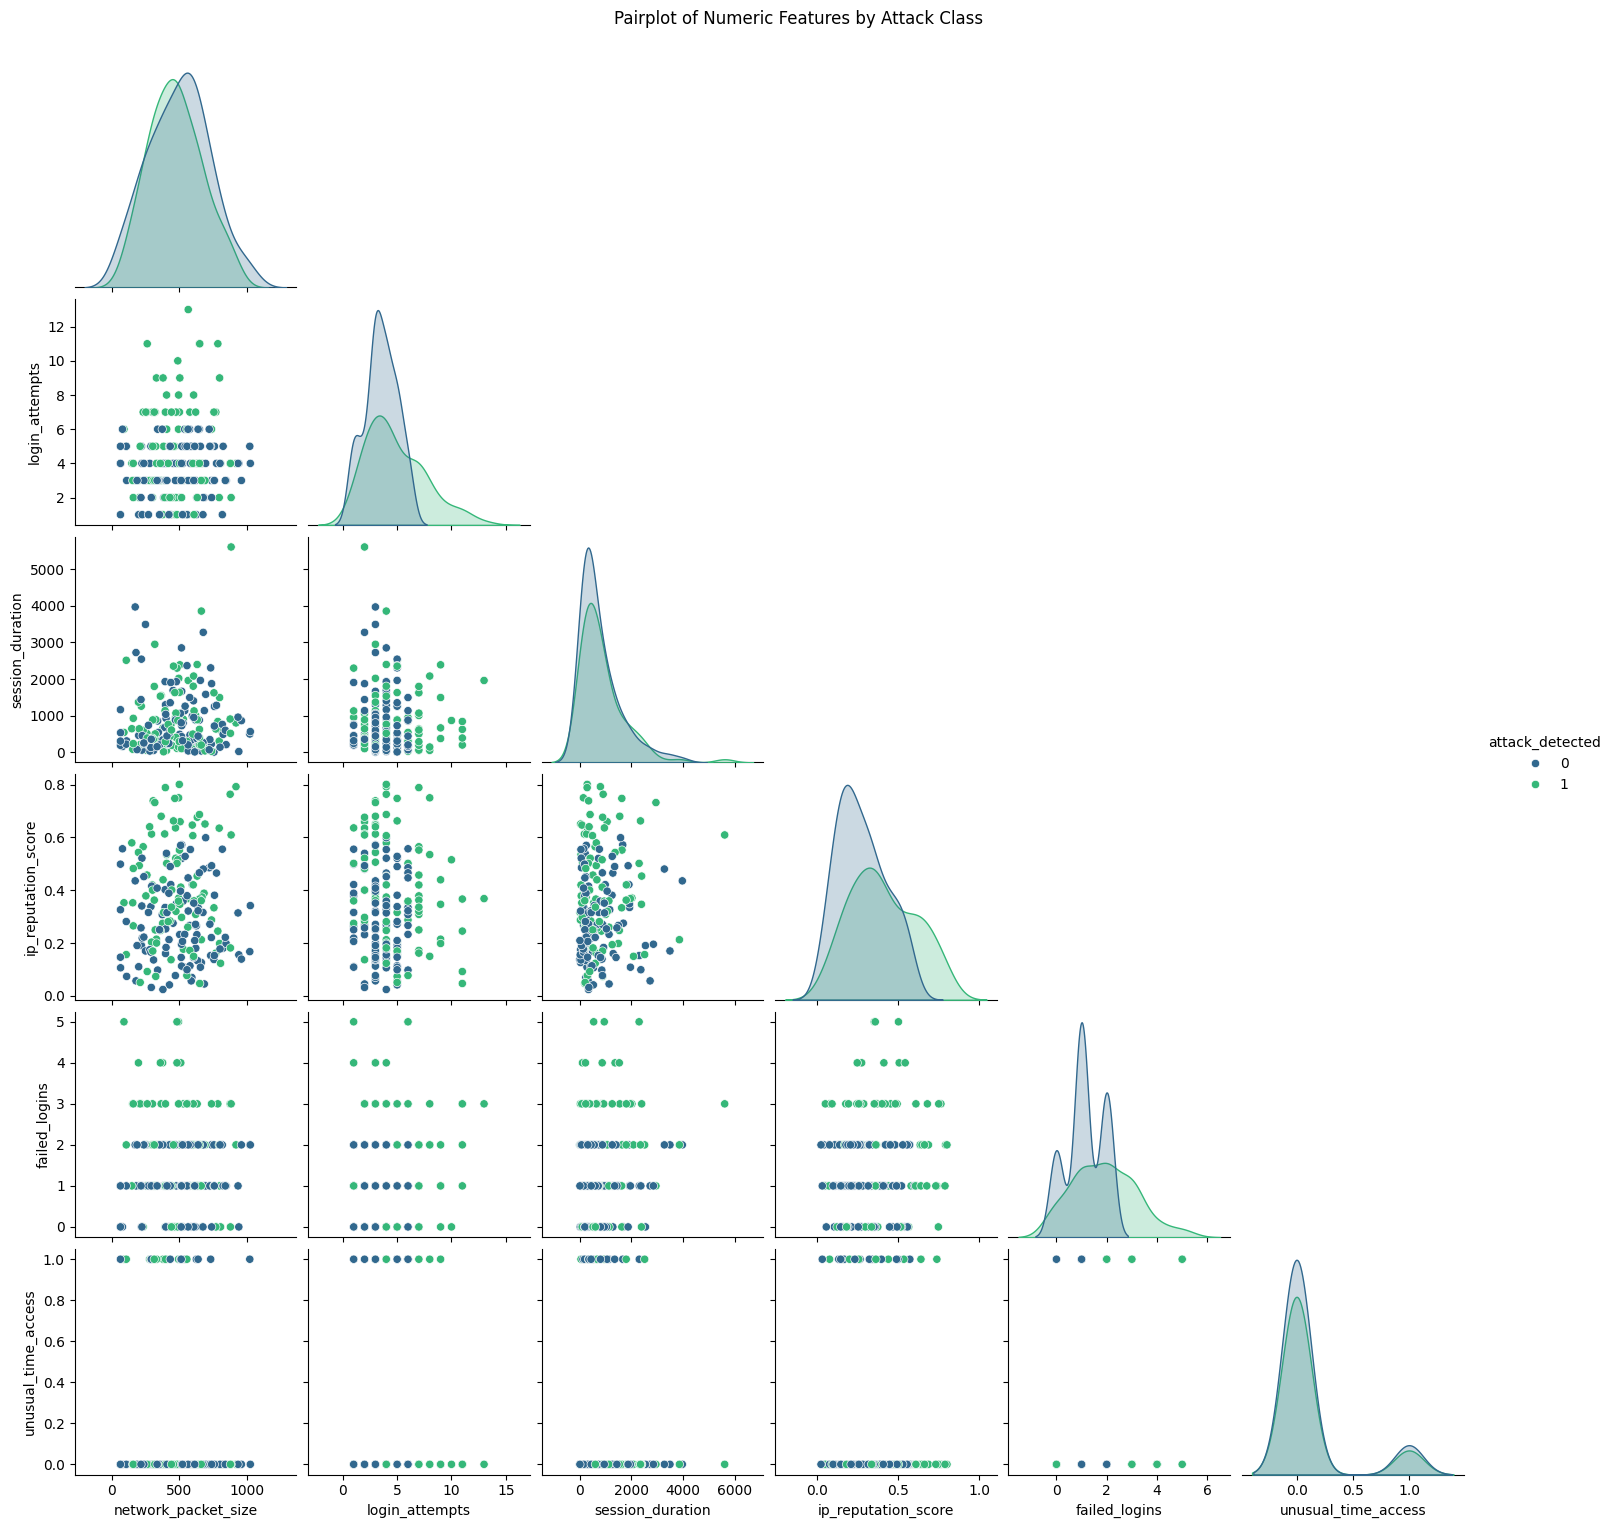

In [73]:
print("\nGenerating Pairplot...")
sns.pairplot(data, vars=numeric_features_eda, hue='attack_detected', palette='viridis', corner=True)
plt.suptitle('Pairplot of Numeric Features by Attack Class', y=1.02)
plt.savefig('eda_pairplot.png')
plt.show()

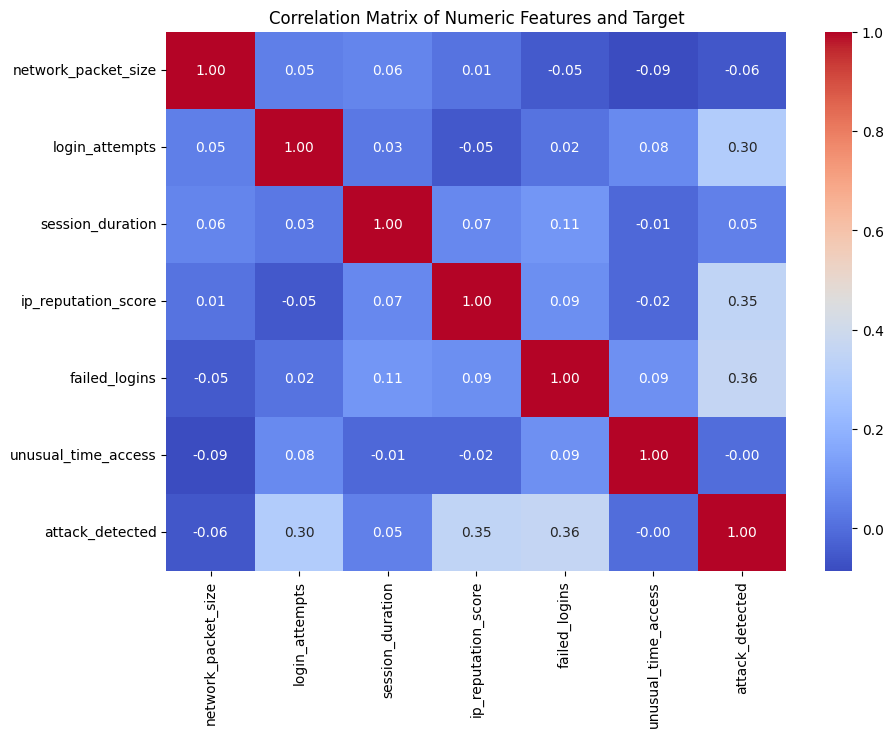

In [74]:
# Correlation Matrix
plt.figure(figsize=(10, 7))
corr_matrix = data[numeric_features_eda + ['attack_detected']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features and Target')
plt.savefig('eda_correlation_heatmap.png')
plt.show()


Generating Categorical Plots...


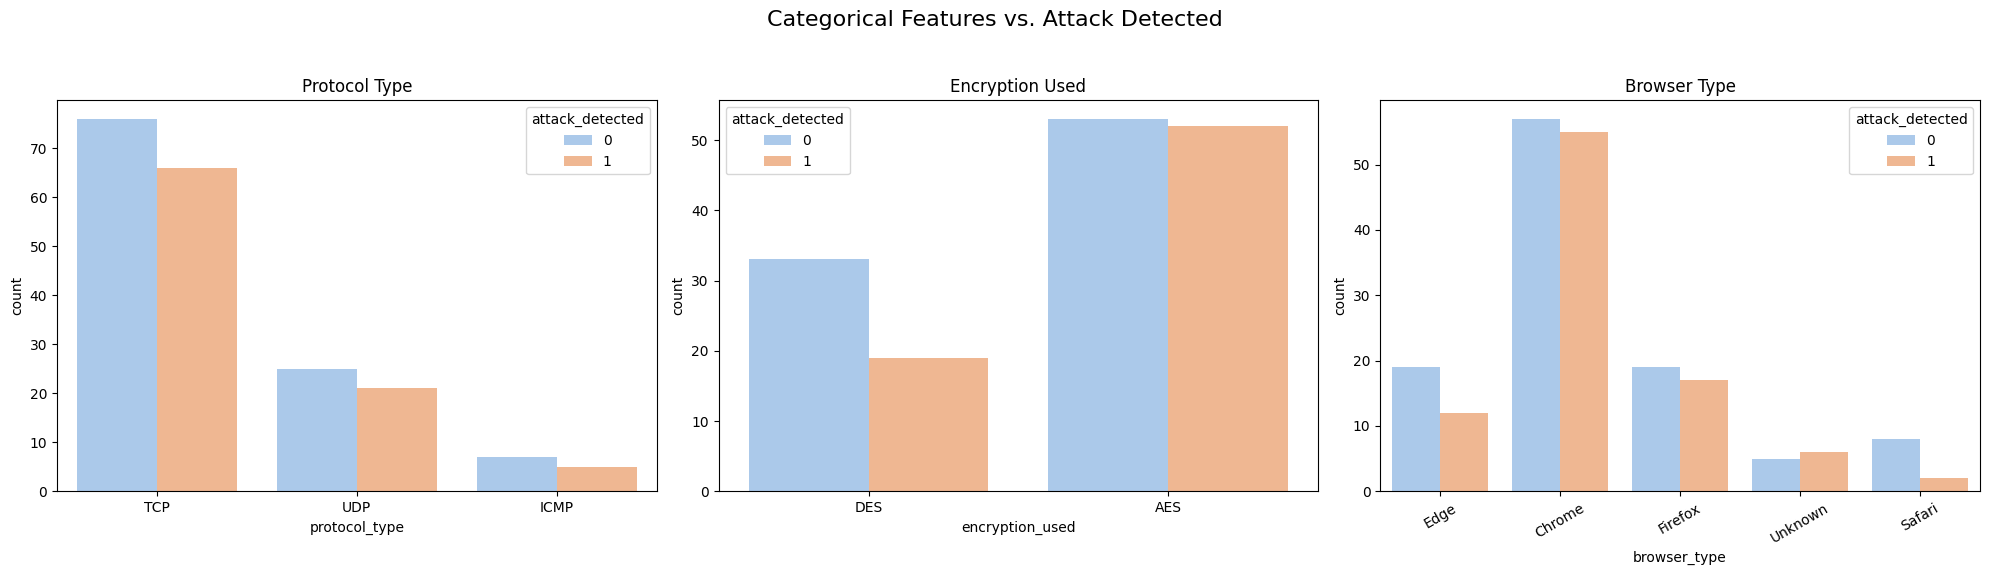

In [75]:
# --- 4. Categorical Feature Analysis ---
categorical_features_eda = ['protocol_type', 'encryption_used', 'browser_type']

print("\nGenerating Categorical Plots...")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Categorical Features vs. Attack Detected', fontsize=16)

sns.countplot(data=data, x='protocol_type', hue='attack_detected', ax=axes[0], palette='pastel')
axes[0].set_title('Protocol Type')

sns.countplot(data=data, x='encryption_used', hue='attack_detected', ax=axes[1], palette='pastel')
axes[1].set_title('Encryption Used')

sns.countplot(data=data, x='browser_type', hue='attack_detected', ax=axes[2], palette='pastel')
axes[2].set_title('Browser Type')
axes[2].tick_params(axis='x', rotation=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('eda_categorical_plots.png')
plt.show()

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [77]:
# Load the 200-point sample dataset
file_name = 'cybersecurity_sample_filled.csv'
data = pd.read_csv(file_name)

In [78]:
# --- 1. Define Features and Target ---
numeric_features = [
    'network_packet_size', 'login_attempts', 'session_duration', 
    'ip_reputation_score', 'failed_logins', 'unusual_time_access'
]
categorical_features = ['protocol_type', 'encryption_used', 'browser_type']
target = 'attack_detected'

X = data[numeric_features + categorical_features]
y = data[target]

In [79]:
# --- 2. Split the Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Data split into {len(X_train)} training samples and {len(X_test)} testing samples.")
print(f"Training set class balance:\n{y_train.value_counts(normalize=True)}")
print(f"\nTest set class balance:\n{y_test.value_counts(normalize=True)}")

Data split into 160 training samples and 40 testing samples.
Training set class balance:
attack_detected
0    0.5375
1    0.4625
Name: proportion, dtype: float64

Test set class balance:
attack_detected
0    0.55
1    0.45
Name: proportion, dtype: float64


In [80]:
# --- 3. Create the Preprocessing Pipeline ---
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [81]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
print("\nPreprocessing ColumnTransformer created.")


Preprocessing ColumnTransformer created.


In [82]:
# Special pipeline for Naive Bayes to handle sparse->dense conversion
nb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_dense', FunctionTransformer(lambda x: x.toarray() if hasattr(x, "toarray") else x)),
    ('model', GaussianNB())
])

In [83]:
# Standard pipelines for other models
pipelines = {
    'Logistic Regression': Pipeline(steps=[('preprocessor', preprocessor),
                                           ('model', LogisticRegression(max_iter=1000, random_state=42))]),
    
    'K-Nearest Neighbors (KNN)': Pipeline(steps=[('preprocessor', preprocessor),
                                                 ('model', KNeighborsClassifier(n_neighbors=5))]),
    
    'Random Forest': Pipeline(steps=[('preprocessor', preprocessor),
                                     ('model', RandomForestClassifier(n_estimators=100, random_state=42))]),
    
    'Naive Bayes': nb_pipeline
}

In [84]:
print("Four model pipelines (LR, KNN, RF, NB) are defined and ready for training.")

Four model pipelines (LR, KNN, RF, NB) are defined and ready for training.


Model Evaluation

--- 5. Final Model Evaluation on Hold-Out Test Set (40 samples) ---

--- Logistic Regression Classification Report (Test Set) ---
               precision    recall  f1-score   support

   Normal (0)       0.71      0.77      0.74        22
Intrusion (1)       0.69      0.61      0.65        18

     accuracy                           0.70        40
    macro avg       0.70      0.69      0.69        40
 weighted avg       0.70      0.70      0.70        40


--- K-Nearest Neighbors (KNN) Classification Report (Test Set) ---
               precision    recall  f1-score   support

   Normal (0)       0.68      0.77      0.72        22
Intrusion (1)       0.67      0.56      0.61        18

     accuracy                           0.68        40
    macro avg       0.67      0.66      0.66        40
 weighted avg       0.67      0.68      0.67        40


--- Random Forest Classification Report (Test Set) ---
               precision    recall  f1-score   support

   Normal (0)       0.76

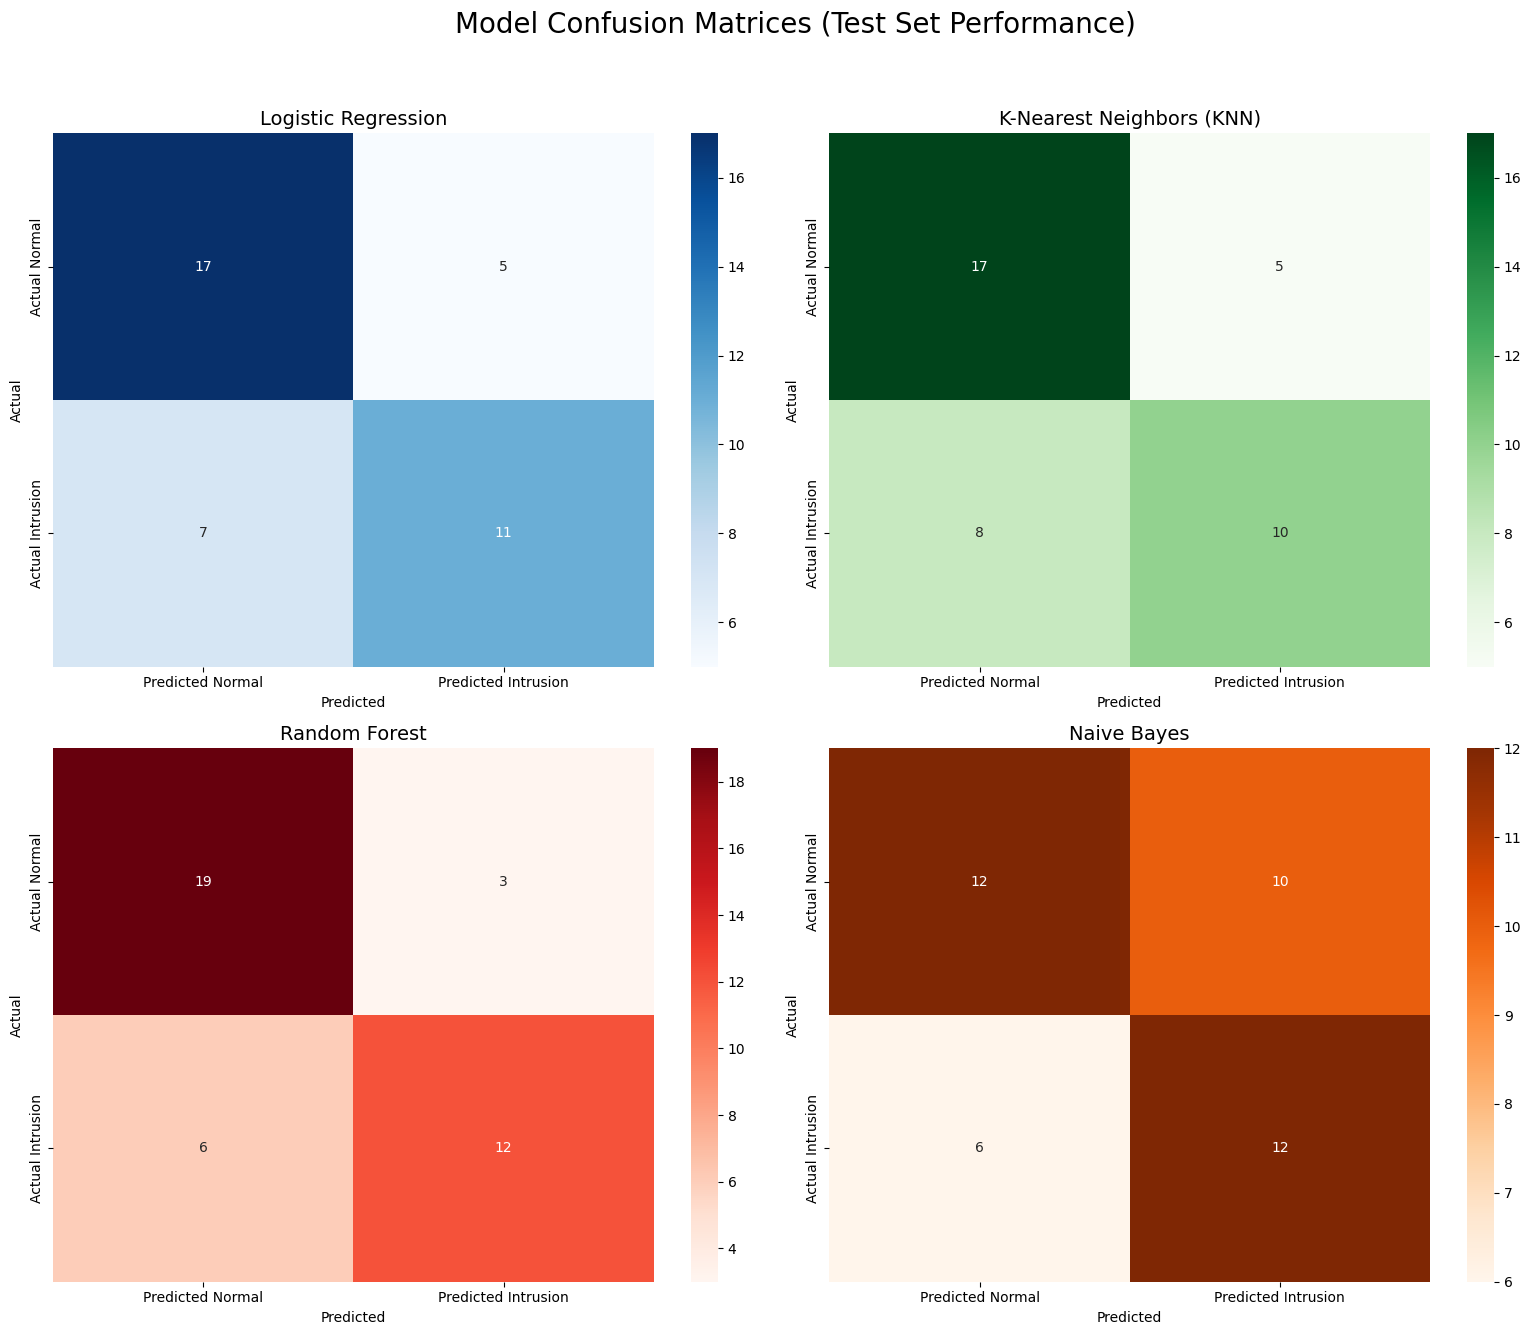


All 4 models have been trained and confusion matrices plotted.


In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer # Ensure this is imported



print("--- 5. Final Model Evaluation on Hold-Out Test Set (40 samples) ---")

# We will store the final trained pipelines
fitted_pipelines = {}
test_metrics = []

# --- Create a 2x2 subplot for confusion matrices ---
fig_cm, axes_cm = plt.subplots(2, 2, figsize=(16, 14))
fig_cm.suptitle('Model Confusion Matrices (Test Set Performance)', fontsize=20)
cm_colors = ['Blues', 'Greens', 'Reds', 'Oranges']
model_names = list(pipelines.keys())

for i, (name, pipeline) in enumerate(pipelines.items()):
    # --- Train on the FULL training set ---
    # We need to handle the dense/sparse issue for Naive Bayes again
    if name == 'Naive Bayes':
        nb_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('to_dense', FunctionTransformer(lambda x: x.toarray() if hasattr(x, "toarray") else x)),
            ('model', GaussianNB())
        ])
        nb_pipeline.fit(X_train, y_train)
        fitted_pipelines[name] = nb_pipeline # Save fitted pipeline
        y_pred = nb_pipeline.predict(X_test)
    else:
        pipeline.fit(X_train, y_train)
        fitted_pipelines[name] = pipeline # Save fitted pipeline
        y_pred = pipeline.predict(X_test)

    print(f"\n--- {name} Classification Report (Test Set) ---")
    print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Intrusion (1)'], zero_division=0))

    # (Storing metrics for the bar plot - can be omitted if *only* CMatrix is needed)
    test_metrics.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision (Intrusion)': precision_score(y_test, y_pred, zero_division=0),
        'Recall (Intrusion)': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score (Intrusion)': f1_score(y_test, y_pred, zero_division=0)
    })
    
    # --- Plot Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    ax = axes_cm[i//2, i%2] # Get the correct subplot (e.g., [0,0], [0,1], [1,0], [1,1])
    sns.heatmap(cm, annot=True, fmt='d', cmap=cm_colors[i], ax=ax,
                xticklabels=['Predicted Normal', 'Predicted Intrusion'],
                yticklabels=['Actual Normal', 'Actual Intrusion'])
    ax.set_title(name, fontsize=14)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for main title
plt.savefig('test_set_confusion_matrices.png')
plt.show()

print("\nAll 4 models have been trained and confusion matrices plotted.")

In [86]:
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Running 5-Fold Cross-Validation on the 160 training samples...
Logistic Regression | Mean CV Accuracy: 0.769 (± 0.083)
K-Nearest Neighbors (KNN) | Mean CV Accuracy: 0.688 (± 0.044)
Random Forest | Mean CV Accuracy: 0.869 (± 0.070)
Naive Bayes | Mean CV Accuracy: 0.713 (± 0.064)

--- Cross-Validation Results (Estimate of Generalization Error) ---
                    Model  Mean_Accuracy  Std_Dev
            Random Forest          0.869    0.070
      Logistic Regression          0.769    0.083
              Naive Bayes          0.713    0.064
K-Nearest Neighbors (KNN)          0.688    0.044


C:\Users\manis\AppData\Local\Temp\ipykernel_24960\31204995.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


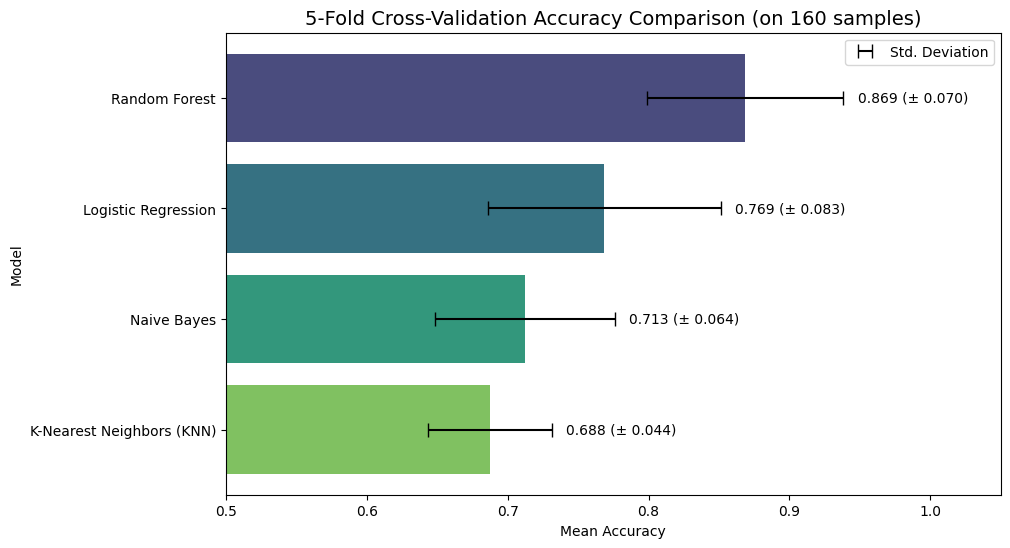

In [87]:
print("Running 5-Fold Cross-Validation on the 160 training samples...")

model_names = []
cv_accuracies = []
cv_std_devs = []

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='accuracy')
    
    model_names.append(name)
    cv_accuracies.append(np.mean(scores))
    cv_std_devs.append(np.std(scores))
    
    print(f"{name} | Mean CV Accuracy: {np.mean(scores):.3f} (± {np.std(scores):.3f})")

cv_results_df = pd.DataFrame({
    'Model': model_names,
    'Mean_Accuracy': cv_accuracies,
    'Std_Dev': cv_std_devs
})

cv_results_df = cv_results_df.sort_values(by='Mean_Accuracy', ascending=False)

print("\n--- Cross-Validation Results (Estimate of Generalization Error) ---")
# Avoid requiring the optional 'tabulate' package used by to_markdown; use to_string instead
print(cv_results_df.to_string(index=False, float_format="%.3f"))

plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=cv_results_df,
    x='Mean_Accuracy',
    y='Model',
    palette='viridis'
)

plt.errorbar(
    x=cv_results_df['Mean_Accuracy'],
    y=cv_results_df['Model'],
    xerr=cv_results_df['Std_Dev'],
    fmt='none',
    c='black',
    capsize=5,
    label='Std. Deviation'
)

plt.title(f'{k}-Fold Cross-Validation Accuracy Comparison (on 160 samples)', fontsize=14)
plt.xlabel('Mean Accuracy')
plt.ylabel('Model')
plt.xlim(0.5, 1.05)
plt.legend()

for i, (model_name, acc, std) in enumerate(cv_results_df.itertuples(index=False)):
    plt.text(acc + std + 0.01, i, f'{acc:.3f} (± {std:.3f})', va='center')

plt.savefig('cv_results_barplot.png')
plt.show()

Running bootstrapping (100 iterations) to estimate accuracy distribution...
Bootstrapping complete.


C:\Users\manis\AppData\Local\Temp\ipykernel_24960\1376044263.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=bootstrap_melted, x='Model', y='Accuracy', palette='viridis')


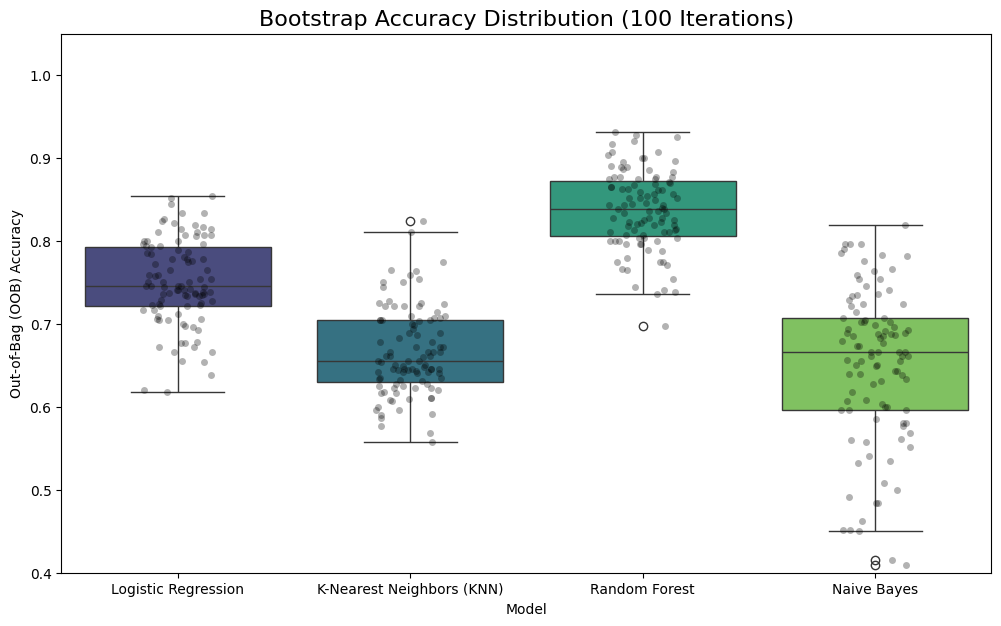


--- Bootstrap Accuracy Statistics ---
Logistic Regression | Mean OOB Accuracy: 0.750 (± 0.052)
K-Nearest Neighbors (KNN) | Mean OOB Accuracy: 0.666 (± 0.052)
Random Forest | Mean OOB Accuracy: 0.837 (± 0.047)
Naive Bayes | Mean OOB Accuracy: 0.650 (± 0.093)


In [88]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score


print("Running bootstrapping (100 iterations) to estimate accuracy distribution...")

n_iterations = 100
bootstrap_results = {name: [] for name in pipelines.keys()}

preprocessor_fitted = preprocessor.fit(X_train)

ohe_feature_names = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, ohe_feature_names])

X_train_processed_array = preprocessor_fitted.transform(X_train)
if hasattr(X_train_processed_array, "toarray"):
    X_train_processed_df = pd.DataFrame(X_train_processed_array.toarray(), columns=all_feature_names, index=X_train.index)
else:
    X_train_processed_df = pd.DataFrame(X_train_processed_array, columns=all_feature_names, index=X_train.index)

y_train_series = y_train.copy()

for i in range(n_iterations):
    # Create a bootstrap sample (sampling with replacement)
    X_boot, y_boot = resample(X_train_processed_df, y_train_series, random_state=i)
    
    # Create the "out-of-bag" (OOB) sample
    oob_indices = [idx for idx in X_train_processed_df.index if idx not in X_boot.index]
    
    if not oob_indices: # Skip if OOB is empty
        continue
        
    X_oob = X_train_processed_df.loc[oob_indices]
    y_oob = y_train_series.loc[oob_indices]

    for name, pipeline in pipelines.items():
        # Extract the model step (data is already processed)
        model = pipeline.named_steps['model']
        
        # Fit on bootstrap sample
        model.fit(X_boot, y_boot)
        
        # Evaluate on OOB sample
        y_pred_oob = model.predict(X_oob)
        accuracy = accuracy_score(y_oob, y_pred_oob)
        
        bootstrap_results[name].append(accuracy)

print("Bootstrapping complete.")

# Convert results to DataFrame for plotting
bootstrap_df = pd.DataFrame(bootstrap_results)
bootstrap_melted = bootstrap_df.melt(var_name='Model', value_name='Accuracy')

# Plot the Bootstrap Results
plt.figure(figsize=(12, 7))
sns.boxplot(data=bootstrap_melted, x='Model', y='Accuracy', palette='viridis')
sns.stripplot(data=bootstrap_melted, x='Model', y='Accuracy', color='black', alpha=0.3, jitter=0.15)

plt.title(f'Bootstrap Accuracy Distribution ({n_iterations} Iterations)', fontsize=16)
plt.ylabel('Out-of-Bag (OOB) Accuracy')
plt.xlabel('Model')
plt.ylim(0.4, 1.05)
plt.savefig('bootstrap_results_boxplot.png')
plt.show()

print("\n--- Bootstrap Accuracy Statistics ---")
for name in pipelines.keys():
    accuracies = bootstrap_results[name]
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    print(f"{name} | Mean OOB Accuracy: {mean_acc:.3f} (± {std_acc:.3f})")

INTERACTIVE USE OF MODELS


In [89]:
import warnings
import pandas as pd
import numpy as np

In [90]:
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

# Ensure there are fitted pipelines available for prediction.
# If not already present in the notebook state, fit each pipeline on the training data.
if 'fitted_pipelines' not in globals():
    fitted_pipelines = {}
    for name, pipeline in pipelines.items():
        try:
            print(f"Fitting pipeline: {name} ...")
            fitted_pipeline = pipeline.fit(X_train, y_train)
            fitted_pipelines[name] = fitted_pipeline
        except Exception as e:
            # Keep going if one pipeline fails to fit; report the error.
            print(f"Failed to fit pipeline '{name}': {e}")

def predict_intrusion(input_data):
    """
    Takes a dictionary of user inputs, processes it through
    the fitted pipelines, and returns predictions from all 4 models.
    """
    
    # Define all expected features based on the trained preprocessor
    expected_keys = numeric_features + categorical_features
    
    try:
        input_df = pd.DataFrame([input_data])
        input_df = input_df[expected_keys] # Ensure column order
    except KeyError as e:
        print(f"Error: Missing input feature: {e}")
        print(f"Please provide all 9 features: {expected_keys}")
        return
    except Exception as e:
        print(f"Error creating DataFrame: {e}")
        return
        
    print(f"--- Input Data ---")
    # Use to_string to avoid optional external dependencies
    print(input_df.to_string(index=False))
    
    print("\n--- Model Predictions ---")
    predictions = {}
    
    for name, pipeline in fitted_pipelines.items():
        try:
            pred = pipeline.predict(input_df)[0]
            
            if hasattr(pipeline.named_steps['model'], "predict_proba"):
                # Special handling for NB pipeline's proba
                if name == 'Naive Bayes':
                    processed_input = pipeline.named_steps['preprocessor'].transform(input_df)
                    dense_input = pipeline.named_steps['to_dense'].transform(processed_input)
                    prob = pipeline.named_steps['model'].predict_proba(dense_input)[0][1]
                else:
                    prob = pipeline.predict_proba(input_df)[0][1] # Probability of class 1
                prob_str = f"{prob:.1%}"
            else:
                prob_str = "N/A"
                
            result = "**INTRUSION**" if pred == 1 else "Normal"
            predictions[name] = {'Prediction': result, 'Intrusion Probability': prob_str}

        except Exception as e:
            predictions[name] = {'Prediction': f"Error: {e}", 'Intrusion Probability': "N/A"}

    pred_df = pd.DataFrame(predictions).T
    print(pred_df.to_string())


In [91]:
print("--- Example 1: Simulating a suspicious session ---")
suspicious_session = {
    'failed_logins': 3,
    'ip_reputation_score': 0.75, # High
    'login_attempts': 4,
    'session_duration': 10.5, # Very short
    'network_packet_size': 800,
    'browser_type': 'Unknown',
    'protocol_type': 'UDP',
    'unusual_time_access': 1, # Unusual
    'encryption_used': 'DES'
}
predict_intrusion(suspicious_session)


print("\n\n--- Example 2: Simulating a normal session ---")
normal_session = {
    'failed_logins': 0,
    'ip_reputation_score': 0.15, # Low
    'login_attempts': 1,
    'session_duration': 1200.0, # Long
    'network_packet_size': 350,
    'browser_type': 'Chrome',
    'protocol_type': 'TCP',
    'unusual_time_access': 0, # Not unusual
    'encryption_used': 'AES'
}
predict_intrusion(normal_session)

--- Example 1: Simulating a suspicious session ---
--- Input Data ---
 network_packet_size  login_attempts  session_duration  ip_reputation_score  failed_logins  unusual_time_access protocol_type encryption_used browser_type
                 800               4              10.5                 0.75              3                    1           UDP             DES      Unknown

--- Model Predictions ---
                              Prediction Intrusion Probability
Logistic Regression        **INTRUSION**                 99.8%
K-Nearest Neighbors (KNN)  **INTRUSION**                 60.0%
Random Forest              **INTRUSION**                 89.0%
Naive Bayes                **INTRUSION**                100.0%


--- Example 2: Simulating a normal session ---
--- Input Data ---
 network_packet_size  login_attempts  session_duration  ip_reputation_score  failed_logins  unusual_time_access protocol_type encryption_used browser_type
                 350               1            1200.0 